In [17]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
words = open("names.txt", "r").read().splitlines()
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)

In [19]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([208959, 3]) torch.Size([208959])
torch.Size([26069, 3]) torch.Size([26069])
torch.Size([26243, 3]) torch.Size([26243])


In [20]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the character embeddding vector
n_hidden = 100 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47777


In [21]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1) # concatenate vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 1.0 if i < 100000 else 0.1 # learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

      0/ 200000: 3.3502
  10000/ 200000: 2.2943
  20000/ 200000: 2.1141
  30000/ 200000: 1.9407
  40000/ 200000: 2.4931
  50000/ 200000: 2.3062
  60000/ 200000: 2.3288
  70000/ 200000: 2.2184
  80000/ 200000: 2.3203
  90000/ 200000: 1.7480
 100000/ 200000: 1.9529
 110000/ 200000: 2.1004
 120000/ 200000: 1.7572
 130000/ 200000: 1.9903
 140000/ 200000: 2.0646
 150000/ 200000: 2.0485
 160000/ 200000: 1.9049
 170000/ 200000: 2.0149
 180000/ 200000: 2.4864
 190000/ 200000: 2.1192


layer 2 (      Tanh): mean -0.01, std: +0.78, saturated: 27.25%
layer 5 (      Tanh): mean -0.02, std: +0.79, saturated: 26.94%
layer 8 (      Tanh): mean -0.03, std: +0.80, saturated: 26.63%
layer 11 (      Tanh): mean -0.01, std: +0.79, saturated: 25.53%
layer 14 (      Tanh): mean +0.07, std: +0.82, saturated: 32.72%


Text(0.5, 1.0, 'activation distribution')

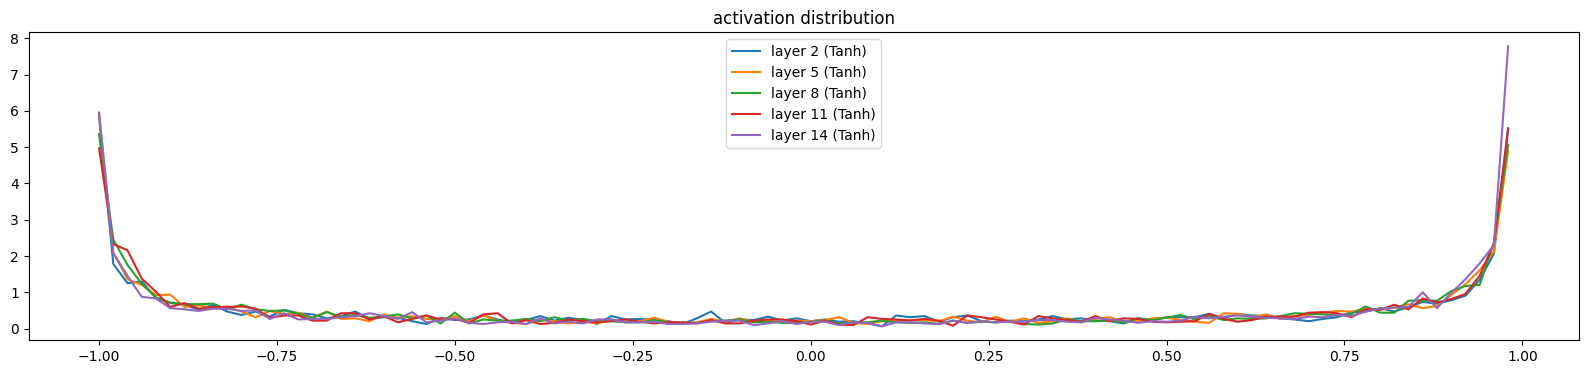

In [22]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print("layer %d (%10s): mean %+.2f, std: %+.2f, saturated: %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("activation distribution")

layer 2 (      Tanh): mean -0.000000, std: 4.633346e-03
layer 5 (      Tanh): mean -0.000000, std: 4.169500e-03
layer 8 (      Tanh): mean +0.000000, std: 4.004664e-03
layer 11 (      Tanh): mean -0.000000, std: 3.976436e-03
layer 14 (      Tanh): mean +0.000000, std: 3.933825e-03


Text(0.5, 1.0, 'gradient distribution')

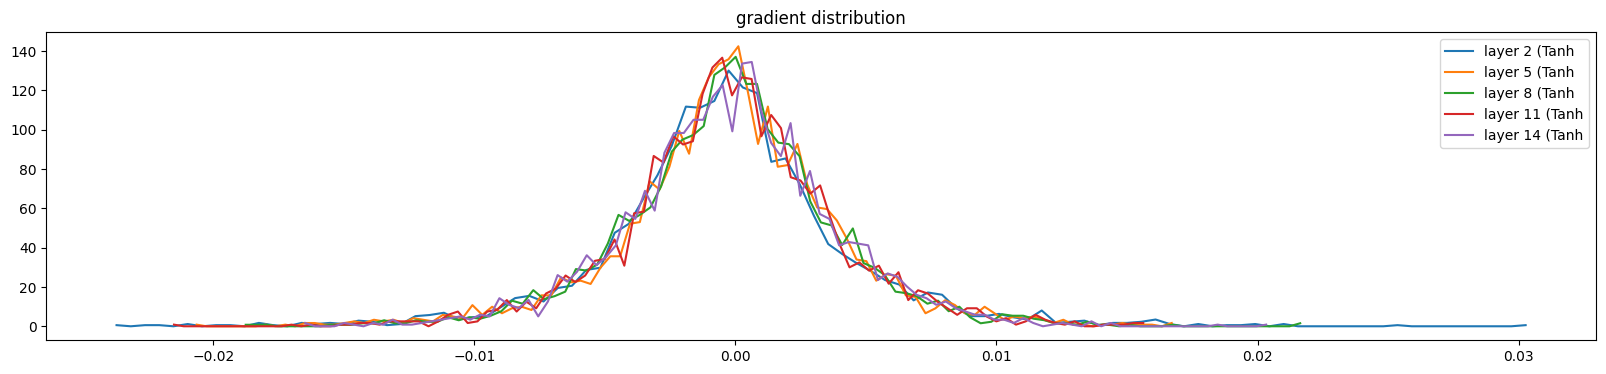

In [23]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print("layer %d (%10s): mean %+f, std: %e" % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("gradient distribution")

weight:   (29, 10) | mean: -0.000000 | std: 5.767429e-03 | grad:data ratio: 2.174424e-03
weight:  (30, 100) | mean: -0.000015 | std: 3.055460e-03 | grad:data ratio: 2.179322e-03
weight: (100, 100) | mean: -0.000017 | std: 1.565715e-03 | grad:data ratio: 1.422897e-03
weight: (100, 100) | mean: -0.000004 | std: 1.433099e-03 | grad:data ratio: 1.316290e-03
weight: (100, 100) | mean: +0.000026 | std: 1.380643e-03 | grad:data ratio: 1.276096e-03
weight: (100, 100) | mean: -0.000007 | std: 1.282143e-03 | grad:data ratio: 1.191271e-03
weight:  (100, 29) | mean: -0.000016 | std: 2.364696e-03 | grad:data ratio: 1.917518e-03


Text(0.5, 1.0, 'weights gradient distribution')

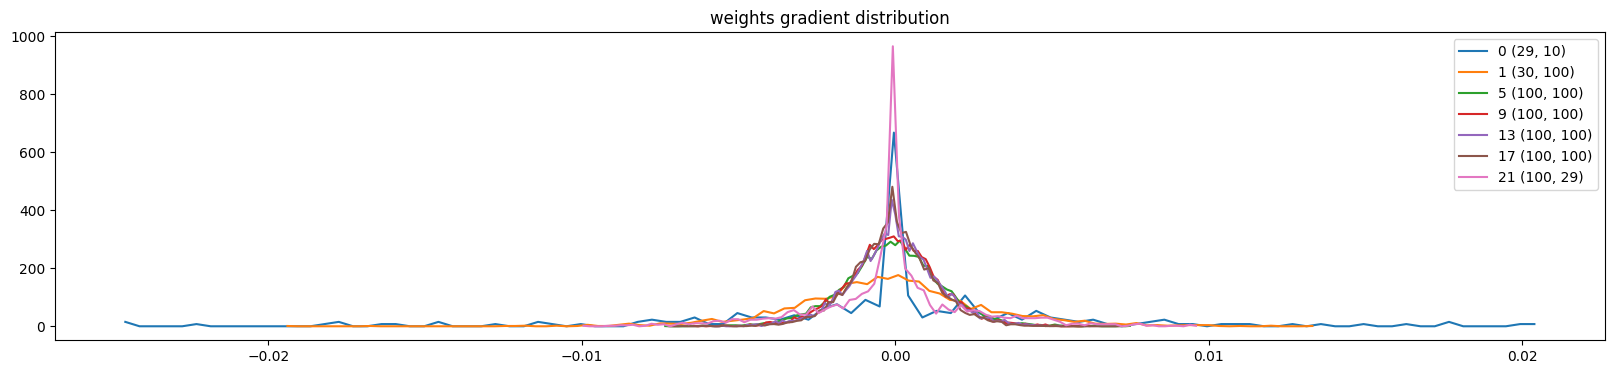

In [24]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print("weight: %10s | mean: %+f | std: %e | grad:data ratio: %e" % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("weights gradient distribution")

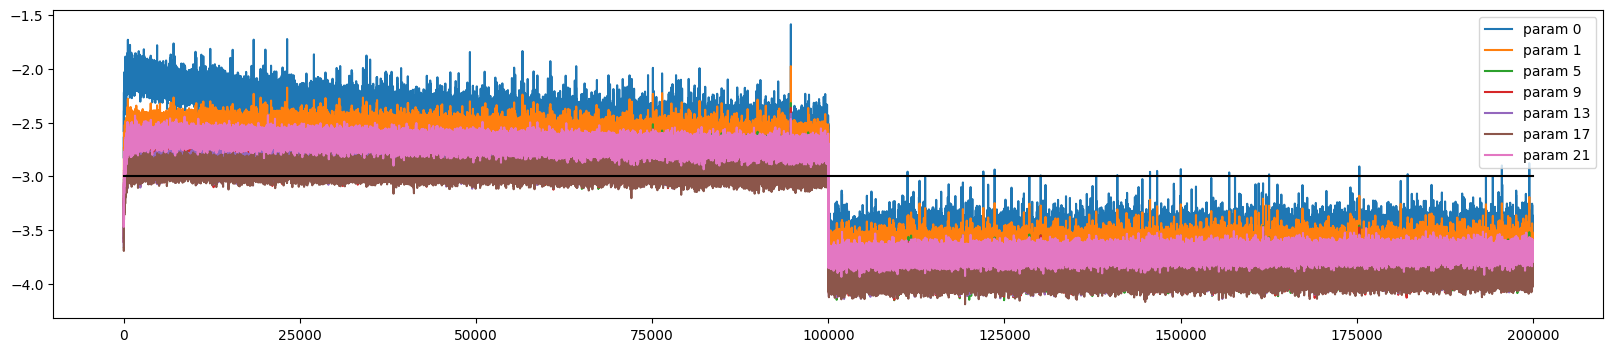

In [25]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3, -3], "k")
plt.legend(legends);

In [26]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

# put layers into eval mode
for layer in layers:
    layer.training = False
split_loss('train')
split_loss('val')

train 2.01930832862854
val 2.085946559906006


In [31]:
for layer in layers:
    layer.training = False

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        # if we sample the special '.' token, break
        if ix == 0:
            break
        else:
            out.append(ix)
    print(''.join(itos[i] for i in out).capitalize()) # decode and print the generated word

Ayines
Jozetto
Ouena
Amarique
Hna
Liouman
Chafkann
Aymeniorgi
Mael
Pros
Aymenana
Doria
Lou eddine
Badrisselyna
Jeos
Loryckolivy
Ouis
Sevangelisshun
Mah
Alisandra
